## Satellite Image Processing with Deep Learning 

# In this notebook we will:
- Solve the EuroSAT-10 classification problem,
- to that end use Convolutional Neural Networks,
- decrease overfitting with dropout,
- decrease overfitting even further with data augmentation, and
- solve the problem with transfer learning. 

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers

In [2]:
histories = {}
epochs = 100
batch_size = 1024

In [3]:
(dataset_train_original, dataset_validate_original, dataset_test_original), info = tfds.load(name="eurosat/rgb", split=["train[:70%]", "train[70%:90%]", "train[90%:]"],with_info=True,as_supervised=True)
print(info)
print("Train:   ", len(list(dataset_train_original)))
print("Validate:", len(list(dataset_validate_original)))
print("Test:    ", len(list(dataset_test_original)))

Shuffling and writing examples to /root/tensorflow_datasets/eurosat/rgb/2.0.0.incompleteTZ06L0/eurosat-train.tfrecord


Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='eurosat',
    version=2.0.0,
    description='EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
bands and consisting of 10 classes with 27000 labeled and
geo-referenced samples.

Two datasets are offered:
- rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
- all: Contains all 13 bands in the original value range (float32).

URL: https://github.com/phelber/eurosat
',
    homepage='https://github.com/phelber/eurosat',
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=27000,
    splits={
        'train': 27000,
    },
    supervised_keys=('image', 'label'),
    citation="""@misc{helber2017

In [4]:
class_names = ["annual crop", "forest", "herbaceous vegetation", "highway", "industrial", "pasture", "permanent crop", "residential", "river", "sea & lake"]
def label_to_string(label):
  return class_names[label]

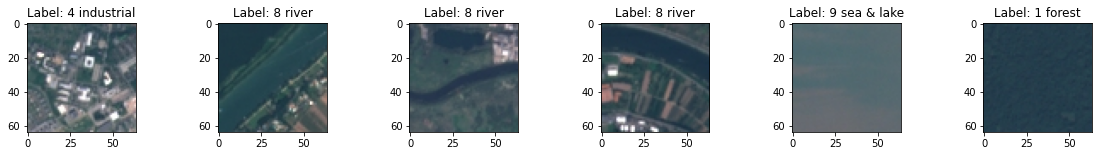

In [5]:
index = 1
plt.figure(figsize=(20, 2))
for dataset_example in dataset_train_original.take(6):
    image, label = dataset_example

    plt.subplot(1, 6, index)
    plt.imshow(image.numpy())
    plt.title("Label: {} {}".format(label.numpy(), label_to_string(label.numpy())))
    index += 1
plt.show()
plt.close()

In [6]:
def encode(image, label):
    image_encoded = tf.image.convert_image_dtype(image, dtype=tf.float32)
    label_encoded = tf.one_hot(label, depth=10)
    return image_encoded, label_encoded

dataset_train = dataset_train_original.map(lambda image, label: encode(image, label)).cache()
dataset_validate = dataset_validate_original.map(lambda image, label: encode(image, label)).cache()
dataset_test = dataset_test_original.map(lambda image, label: encode(image, label)).cache()

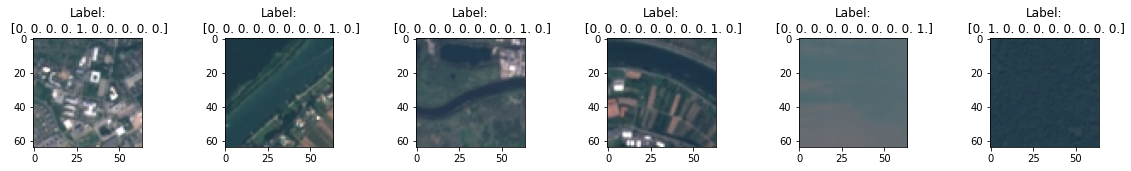

In [7]:
index = 1
plt.figure(figsize=(20, 2))
for dataset_example in dataset_train.take(6):
    image, label = dataset_example

    plt.subplot(1, 6, index)
    plt.imshow(image.numpy())
    plt.title("Label:\n {}".format(label.numpy()))
    index += 1
plt.show()
plt.close()

In [8]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=(64, 64, 3)))
model.add(layers.Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation="relu", padding="same"))
model.add(layers.Conv2D(64, (3, 3), activation="relu", padding="same"))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation="relu", padding="same"))
model.add(layers.Conv2D(128, (3, 3), activation="relu", padding="same"))

model.add(layers.Flatten())

model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(10, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 128)       7

In [9]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [10]:
loss, acc = model.evaluate(dataset_test.batch(32), verbose=0)
print("Loss: {}".format(loss))
print("Accuracy: {}".format(acc))

Loss: 2.303969621658325
Accuracy: 0.05407407507300377


In [11]:
history = model.fit(
    dataset_train.shuffle(10000).batch(batch_size),
    epochs=epochs,
    validation_data=dataset_validate.batch(batch_size)
)

histories["Baseline"] = history

Epoch 1/100
19/19 [==============================] - 10s 539ms/step - loss: 2.0198 - accuracy: 0.2257 - val_loss: 1.7875 - val_accuracy: 0.3254
Epoch 2/100
19/19 [==============================] - 6s 297ms/step - loss: 1.5585 - accuracy: 0.3970 - val_loss: 1.4461 - val_accuracy: 0.4154
Epoch 3/100
19/19 [==============================] - 6s 299ms/step - loss: 1.3684 - accuracy: 0.4752 - val_loss: 1.2134 - val_accuracy: 0.5220
Epoch 4/100
19/19 [==============================] - 6s 301ms/step - loss: 1.1977 - accuracy: 0.5515 - val_loss: 1.0622 - val_accuracy: 0.6276
Epoch 5/100
19/19 [==============================] - 6s 302ms/step - loss: 1.0225 - accuracy: 0.6232 - val_loss: 0.9639 - val_accuracy: 0.6563
Epoch 6/100
19/19 [==============================] - 6s 302ms/step - loss: 0.8535 - accuracy: 0.6893 - val_loss: 0.8421 - val_accuracy: 0.7007
Epoch 7/100
19/19 [==============================] - 6s 305ms/step - loss: 0.8852 - accuracy: 0.6765 - val_loss: 0.7766 - val_accuracy: 0.720

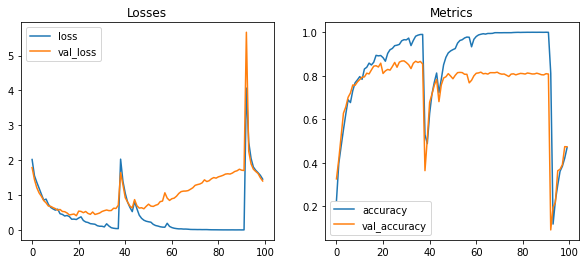

In [12]:
def plot_history(history):
  plt.figure(figsize=(10, 4))

  plt.subplot(1, 2, 1)
  plt.plot(history.history["loss"], label="loss")
  plt.plot(history.history["val_loss"], label="val_loss")
  plt.legend()
  plt.title("Losses")

  plt.subplot(1, 2, 2)
  plt.plot(history.history["accuracy"], label="accuracy")
  plt.plot(history.history["val_accuracy"], label="val_accuracy")
  plt.legend()
  plt.title("Metrics")

  plt.show()
  plt.close()

plot_history(history)

In [13]:
loss, acc = model.evaluate(dataset_test.batch(32), verbose=0)
print("Loss: {}".format(loss))
print("Accuracy: {}".format(acc))

Loss: 1.3839843273162842
Accuracy: 0.4785185158252716


In [14]:
dataset_train = dataset_train_original.map(lambda image, label: encode(image, label)).cache()
dataset_validate = dataset_validate_original.map(lambda image, label: encode(image, label)).cache()
dataset_test = dataset_test_original.map(lambda image, label: encode(image, label)).cache()

In [15]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=(64, 64, 3)))
model.add(layers.Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), activation="relu", padding="same"))
model.add(layers.Conv2D(64, (3, 3), activation="relu", padding="same"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(128, (3, 3), activation="relu", padding="same"))
model.add(layers.Conv2D(128, (3, 3), activation="relu", padding="same"))
model.add(layers.Dropout(0.4))

model.add(layers.Flatten())

model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation="softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 64)       

Epoch 1/100
19/19 [==============================] - 10s 503ms/step - loss: 2.2311 - accuracy: 0.1511 - val_loss: 2.0185 - val_accuracy: 0.2480
Epoch 2/100
19/19 [==============================] - 6s 339ms/step - loss: 1.9318 - accuracy: 0.2538 - val_loss: 1.7818 - val_accuracy: 0.3415
Epoch 3/100
19/19 [==============================] - 6s 339ms/step - loss: 1.7140 - accuracy: 0.3434 - val_loss: 1.4866 - val_accuracy: 0.4161
Epoch 4/100
19/19 [==============================] - 6s 340ms/step - loss: 1.5110 - accuracy: 0.4230 - val_loss: 1.3497 - val_accuracy: 0.4933
Epoch 5/100
19/19 [==============================] - 6s 337ms/step - loss: 1.3787 - accuracy: 0.4949 - val_loss: 1.2573 - val_accuracy: 0.5559
Epoch 6/100
19/19 [==============================] - 6s 339ms/step - loss: 1.2865 - accuracy: 0.5362 - val_loss: 1.1468 - val_accuracy: 0.5826
Epoch 7/100
19/19 [==============================] - 6s 336ms/step - loss: 1.2069 - accuracy: 0.5747 - val_loss: 1.1997 - val_accuracy: 0.534

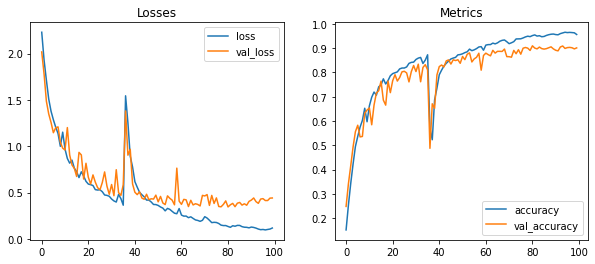

In [16]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    dataset_train.shuffle(10000).batch(batch_size),
    epochs=epochs,
    validation_data=dataset_validate.batch(batch_size)
)

histories["Dropout"] = history

plot_history(history)

In [17]:
def augment(image, label):
    image_augmented = image
    image_augmented = tf.image.random_flip_left_right(image_augmented)
    image_augmented = tf.image.random_flip_up_down(image_augmented)
    image_augmented = tf.image.random_contrast(image_augmented, 0.5, 1.0)
    image_augmented = tf.image.random_brightness(image_augmented, 0.25)
    image_augmented = tf.image.random_hue(image_augmented, 0.2)
    return image_augmented, label

dataset_train = dataset_train_original.map(lambda image, label: encode(image, label)).cache()
dataset_train = dataset_train.map(lambda image, label: augment(image, label))
dataset_validate = dataset_validate_original.map(lambda image, label: encode(image, label)).cache()
dataset_test = dataset_test_original.map(lambda image, label: encode(image, label)).cache()

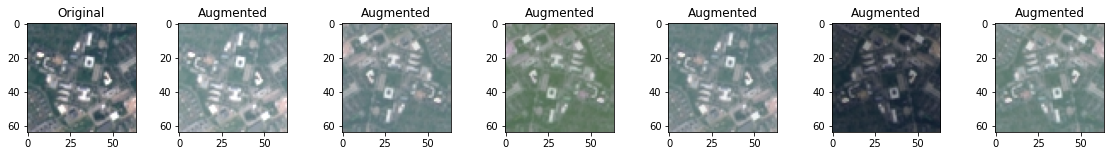

In [18]:
plt.figure(figsize=(20, 2))
index = 1

dataset_example = list(dataset_train_original.take(1))[0]
image, label = dataset_example
plt.subplot(1, 6, index)
plt.imshow(image.numpy())
plt.title("Original")
index += 1

for _ in range(6):
    dataset_example = list(dataset_train.take(1))[0]
    image, label = dataset_example
    plt.subplot(1, 7, index)
    plt.imshow(image.numpy())
    plt.title("Augmented")
    index += 1

plt.show()
plt.close()

In [19]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=(64, 64, 3)))
model.add(layers.Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), activation="relu", padding="same"))
model.add(layers.Conv2D(64, (3, 3), activation="relu", padding="same"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(128, (3, 3), activation="relu", padding="same"))
model.add(layers.Conv2D(128, (3, 3), activation="relu", padding="same"))
model.add(layers.Dropout(0.4))

model.add(layers.Flatten())

model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation="softmax"))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 64)       

Epoch 1/100
19/19 [==============================] - 11s 571ms/step - loss: 2.2325 - accuracy: 0.1535 - val_loss: 2.0878 - val_accuracy: 0.1880
Epoch 2/100
19/19 [==============================] - 8s 423ms/step - loss: 2.0202 - accuracy: 0.2189 - val_loss: 1.8637 - val_accuracy: 0.3172
Epoch 3/100
19/19 [==============================] - 8s 420ms/step - loss: 1.8348 - accuracy: 0.2922 - val_loss: 1.6227 - val_accuracy: 0.3767
Epoch 4/100
19/19 [==============================] - 8s 421ms/step - loss: 1.6838 - accuracy: 0.3404 - val_loss: 1.4323 - val_accuracy: 0.4589
Epoch 5/100
19/19 [==============================] - 8s 420ms/step - loss: 1.5767 - accuracy: 0.3929 - val_loss: 1.3457 - val_accuracy: 0.4796
Epoch 6/100
19/19 [==============================] - 8s 416ms/step - loss: 1.4777 - accuracy: 0.4538 - val_loss: 1.2518 - val_accuracy: 0.5335
Epoch 7/100
19/19 [==============================] - 8s 417ms/step - loss: 1.5534 - accuracy: 0.4334 - val_loss: 1.2860 - val_accuracy: 0.522

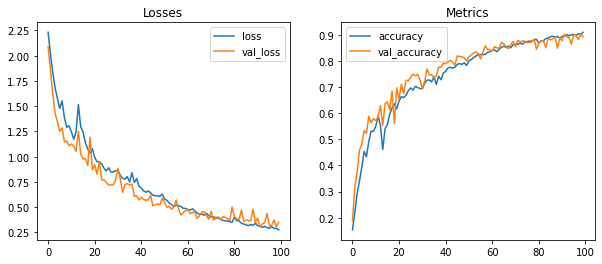

In [20]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    dataset_train.shuffle(10000).batch(batch_size),
    epochs=epochs,
    validation_data=dataset_validate.batch(batch_size)
)

histories["Dropout-Augmentation"] = history

plot_history(history)

In [21]:
dataset_train = dataset_train_original.map(lambda image, label: encode(image, label)).cache()
dataset_train = dataset_train.map(lambda image, label: augment(image, label))
dataset_validate = dataset_validate_original.map(lambda image, label: encode(image, label)).cache()
dataset_test = dataset_test_original.map(lambda image, label: encode(image, label)).cache()

In [22]:
from tensorflow.keras import applications

pretrained_model = applications.VGG19(
    weights="imagenet", 
    include_top=False, 
    input_shape=(64, 64, 3)
)

#for layer in pretrained_model.layers[:-5]:
#  layer.trainable = False

pretrained_model.summary()

pretrained_model.trainable = False

model = models.Sequential()

model.add(pretrained_model)

model.add(layers.Flatten())

model.add(layers.Dropout(0.25))
model.add(layers.Dense(1024, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation="softmax"))

model.summary()

80142336/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
______________________________________________________________

Epoch 1/100
19/19 [==============================] - 16s 846ms/step - loss: 1.7577 - accuracy: 0.3681 - val_loss: 1.0394 - val_accuracy: 0.6370
Epoch 2/100
19/19 [==============================] - 10s 535ms/step - loss: 1.2240 - accuracy: 0.5420 - val_loss: 0.9176 - val_accuracy: 0.6789
Epoch 3/100
19/19 [==============================] - 10s 532ms/step - loss: 1.1001 - accuracy: 0.6010 - val_loss: 0.8704 - val_accuracy: 0.6617
Epoch 4/100
19/19 [==============================] - 10s 541ms/step - loss: 1.0307 - accuracy: 0.6254 - val_loss: 0.7910 - val_accuracy: 0.7204
Epoch 5/100
19/19 [==============================] - 10s 542ms/step - loss: 0.9989 - accuracy: 0.6392 - val_loss: 0.7901 - val_accuracy: 0.7146
Epoch 6/100
19/19 [==============================] - 10s 546ms/step - loss: 0.9687 - accuracy: 0.6492 - val_loss: 0.7662 - val_accuracy: 0.7250
Epoch 7/100
19/19 [==============================] - 10s 544ms/step - loss: 0.9384 - accuracy: 0.6575 - val_loss: 0.7403 - val_accuracy:

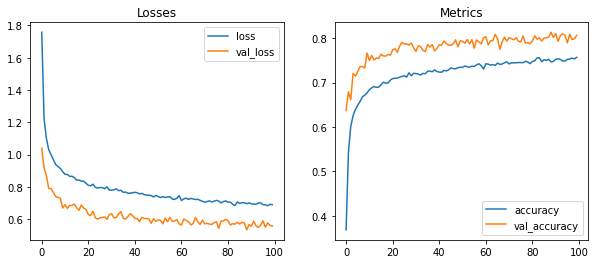

In [23]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    dataset_train.shuffle(10000).batch(batch_size),
    epochs=epochs,
    validation_data=dataset_validate.batch(batch_size)
)

histories["TransferLearning-Dropout-Augmentation"] = history

plot_history(history)

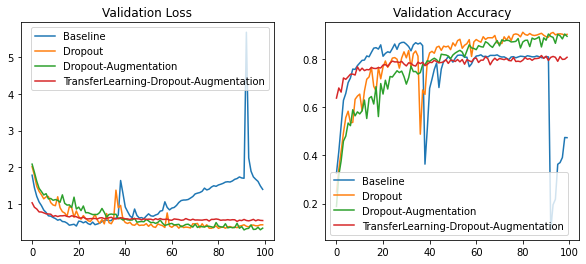

In [24]:
plt.figure(figsize=(10, 4))
  
plt.subplot(1, 2, 1)
for title, history in histories.items():
  plt.plot(history.history["val_loss"], label=title)
plt.legend()
plt.title("Validation Loss")

plt.subplot(1, 2, 2)
for title, history in histories.items():
  plt.plot(history.history["val_accuracy"], label=title)
plt.legend()
plt.title("Validation Accuracy")

plt.show()
plt.close()

### As a Summary.

For solving image processing problems, Convolutional Neural Networks are state of the art. There are several architecures available. We focused on interleaving Convolutional layers with Pooling layers.As with all other use cases, overfitting can be a problem. We looked at Dropout and Data Augmentation for compensating overfitting.